In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abadlibadreddine","key":"477a6d62b5a2f5538a0516a1a6d9ffd2"}'}

In [2]:
import os
import shutil

# Make a Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the uploaded kaggle.json to the kaggle folder
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permission
os.chmod("/root/.kaggle/kaggle.json", 600)

In [3]:
!pip install -q kaggle

# Download the dataset
!kaggle datasets download -d vasukipatel/face-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/vasukipatel/face-recognition-dataset
License(s): CC0-1.0
face-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile

with zipfile.ZipFile("face-recognition-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("face_dataset")


In [5]:
import os

# List people or image folders
os.listdir("face_dataset")

['Dataset.csv',
 'Original Images',
 'Faces',
 'filtered_dataset.csv',
 '.ipynb_checkpoints']

In [6]:
import pandas as pd

# Load the CSV file
csv_path = "face_dataset/Dataset.csv"
df = pd.read_csv(csv_path)

# Show the first few rows
df.head(20)

,id,label
0,Robert Downey Jr_87.jpg,Robert Downey Jr
1,Lisa Kudrow_64.jpg,Lisa Kudrow
2,Ellen Degeneres_34.jpg,Ellen Degeneres
3,Billie Eilish_3.jpg,Billie Eilish
4,Hrithik Roshan_35.jpg,Hrithik Roshan
5,Vijay Deverakonda_39.jpg,Vijay Deverakonda
6,Tom Cruise_21.jpg,Tom Cruise
7,Alia Bhatt_41.jpg,Alia Bhatt
8,Elizabeth Olsen_36.jpg,Elizabeth Olsen
9,Charlize Theron_29.jpg,Charlize Theron


In [ ]:
!pip install -q chromadb
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q ftfy regex tqdm
!pip install -q torchvision

pip install -q chromadb git+https://github.com/openai/CLIP.git ftfy regex tqdm torchvision

  Preparing metadata (setup.py) ... done


In [8]:
import os
import clip
import torch
from PIL import Image
import pandas as pd

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [9]:
# Load the dataset again if needed
filtered_df = pd.read_csv("face_dataset/filtered_dataset.csv")

print(f"Using {len(filtered_df)} images across {filtered_df['label'].nunique()} labels.")

Using 109 images across 11 labels.


In [10]:
filtered_df.head(109)

,id,label,grade
0,Robert Downey Jr_87.jpg,Robert Downey Jr,1
1,Lisa Kudrow_64.jpg,Lisa Kudrow,2
2,Ellen Degeneres_34.jpg,Ellen Degeneres,3
3,Billie Eilish_3.jpg,Billie Eilish,2
4,Hrithik Roshan_35.jpg,Hrithik Roshan,5
...,...,...,...
104,5.jpg,Amine Heddouche,3
105,6.jpg,Amine Heddouche,3
106,7.jpg,Amine Heddouche,3
107,8.jpg,Amine Heddouche,3


In [11]:
face_dir = "face_dataset/Faces/Faces"
image_label_pairs = []

# Match filenames with labels
for _, row in filtered_df.iterrows():
    filename = row["id"]
    label = str(row["label"])  # Ensure it's a string for ChromaDB
    grade = row["grade"]

    face_path = os.path.join(face_dir, filename)
    if os.path.isfile(face_path):
        image_label_pairs.append((face_path, label, grade))

print(f"Total valid face images found: {len(image_label_pairs)}")

Total valid face images found: 109


In [12]:
embeddings = []
metadatas = []
documents = []
ids = []

for i, (img_path, label, grade) in enumerate(image_label_pairs):
    try:
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model.encode_image(image).cpu().numpy()[0]

        embeddings.append(embedding.tolist())
        metadatas.append({"grade": grade})
        documents.append(f"Face of {label}")
        ids.append(f"img_{i}")
    except Exception as e:
        print(f"Failed to process {img_path}: {e}")

In [14]:
import chromadb
from chromadb.config import Settings

# Initialize Chroma client with persistence settings
chroma_client = chromadb.Client(Settings(
    persist_directory="chroma_faces_db"  # Specify a directory for storing the database
))

# Create or load a collection
collection = chroma_client.create_collection(name="faces")

# Add embeddings
collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    documents=documents,
    ids=ids
)


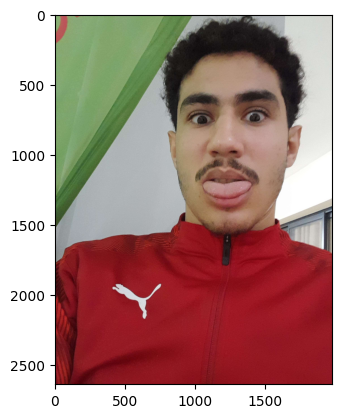

In [19]:
# Pick a sample image and encode it
test_img_path = "/content/test.jpg"

import PIL
import matplotlib.pyplot as plt

test_img = PIL.Image.open(test_img_path)
plt.figure()
plt.imshow(test_img)
plt.show()

In [20]:
# Pick a sample image and encode it
test_image = preprocess(Image.open(test_img_path)).unsqueeze(0).to(device)

with torch.no_grad():
    test_embedding = model.encode_image(test_image).cpu().numpy()[0]

# Query ChromaDB
results = collection.query(
    query_embeddings=[test_embedding.tolist()],
    n_results=1
)

print("Top matches:")
for doc, meta in zip(results["documents"][0], results["metadatas"][0]):
    print(f"- {doc} | Grade: {meta['grade']}")


Top matches:
- Face of Amine Heddouche | Grade: 3
- Face of Amine Heddouche | Grade: 3
- Face of Amine Heddouche | Grade: 3
- Face of Amine Heddouche | Grade: 3
- Face of Amine Heddouche | Grade: 3
